In [11]:
%pip install pandas
%pip install scikit-learn
%pip install plotly
%pip install numpy
%pip install matplotlib
%pip install nbformat
%pip install opencv-python
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import plotly.express as px
from sklearn.model_selection import train_test_split
import random
import os
import csv

from imblearn.over_sampling import SMOTE




In [13]:
emotion_labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}

print(emotion_labels)

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


In [14]:
fer2013_df = pd.read_csv("../../data/raw/fer2013/fer2013.csv", index_col=False)
fer2013_df.drop(columns="Usage", inplace=True)

fer2013_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [15]:
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10

X = fer2013_df["pixels"].values
y = fer2013_df["emotion"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=validation_ratio / (train_ratio + test_ratio)
)

print(len(X_train))
print(len(X_test))
print(len(X_valid))

28709
3589
3589


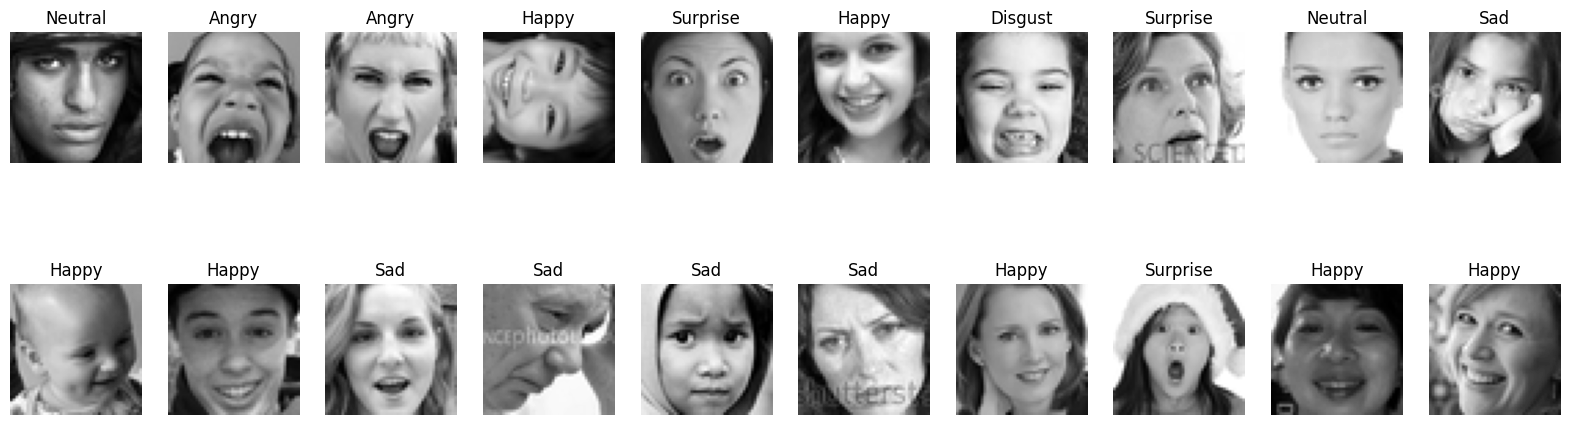

In [16]:


random.seed(42)
random_numbers = [random.randint(0, len(X_train)) for _ in range(20)]

img_list = []
img_labels = []
for idx in random_numbers:
    image_string = X_train[idx].split(" ")
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48, 48)
    img = Image.fromarray(image_data)
    img_list.append(img)
    img_labels.append(y_train[idx])


fig, ax = plt.subplots(2, 10, figsize=(20, 6))
for i, img in enumerate(img_list):
    row, col = divmod(i, 10)
    ax[row, col].imshow(img, cmap="gray")
    ax[row, col].axis("off")
    ax[row, col].set_title(emotion_labels.get(img_labels[i]))

plt.show()

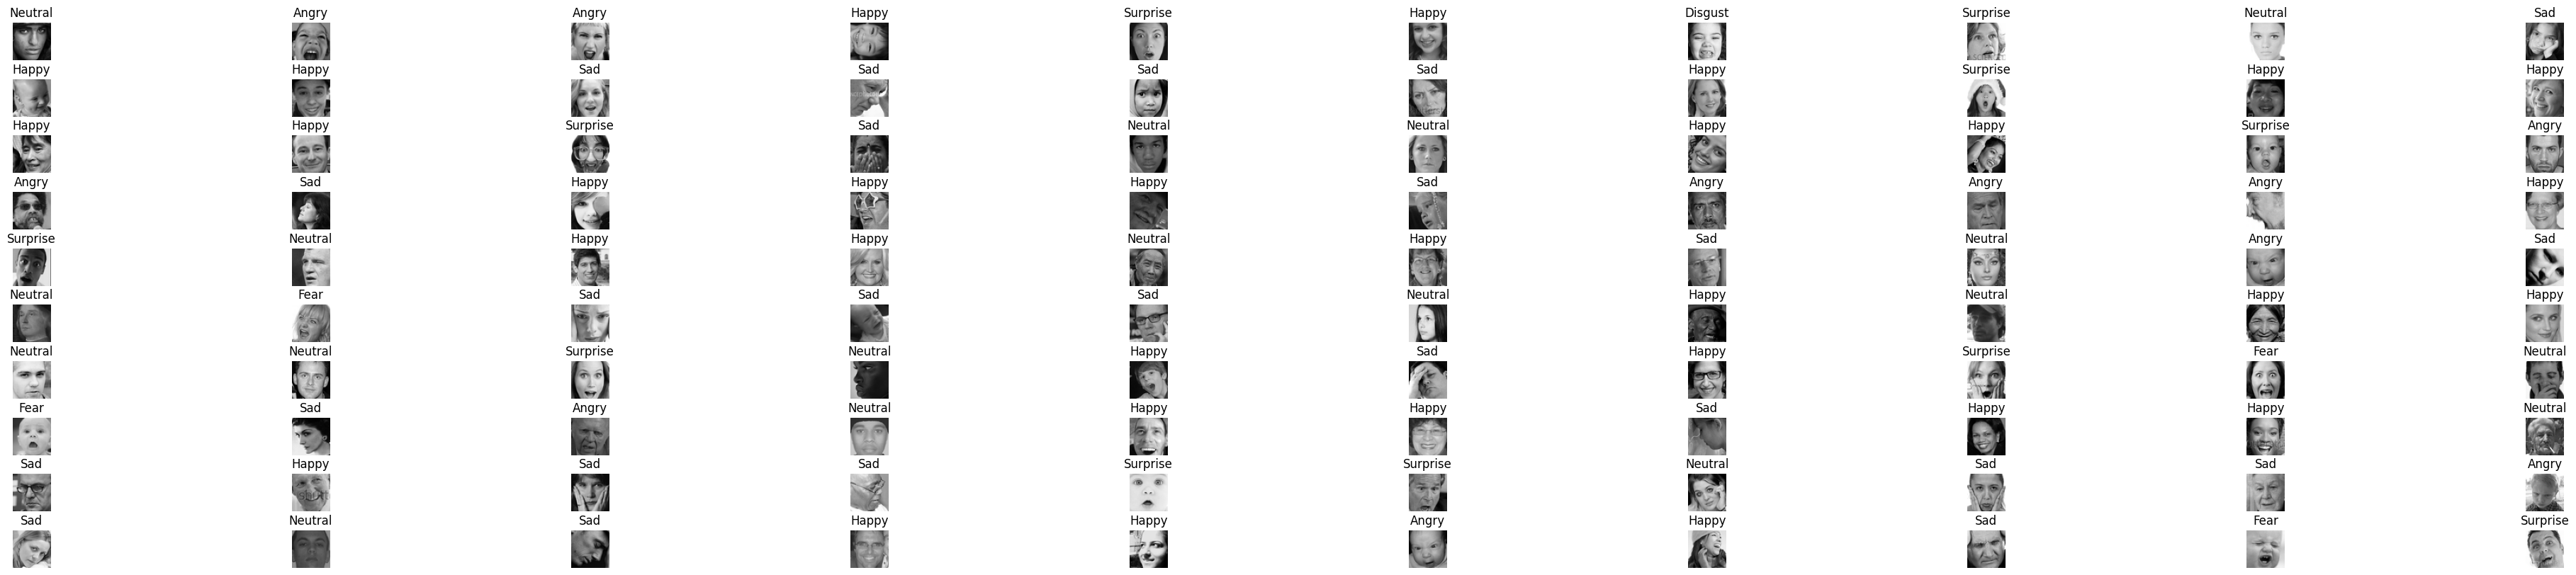

In [17]:
# Look at a hunded Pictures to evaluate how good the data is labelled.

import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(42)
random_numbers = [random.randint(0, len(X_train)) for _ in range(100)]

img_list = []
img_labels = []
for idx in random_numbers:
    image_string = X_train[idx].split(" ")
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48, 48)
    img = cv2.cvtColor(image_data, cv2.COLOR_GRAY2BGR)
    img_list.append(img)
    img_labels.append(y_train[idx])

fig, ax = plt.subplots(10, 10, figsize=(50, 10))
plt.subplots_adjust(hspace=0.5)
for i, img in enumerate(img_list):
    row, col = divmod(i, 10)
    ax[row, col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[row, col].axis("off")
    ax[row, col].set_title(emotion_labels.get(img_labels[i]))

plt.show()

In [18]:
label_counts = {label: np.sum(y_train == label) for label in np.unique(y_train)}

labels = {}
for key, value in label_counts.items():
    labels[emotion_labels.get(key)] = value

In [19]:
fig = px.bar(x=list(labels.keys()), y=list(labels.values()), color=list(labels.keys()))

fig.update_layout(
    title="Total images for each label in training set",
    xaxis_title="Emotion",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [20]:
label_counts_all = {label: np.sum(y == label) for label in np.unique(y)}

labels_all = {}
for key, value in label_counts_all.items():
    labels_all[emotion_labels.get(key)] = value

In [21]:
fig = px.bar(x=list(labels_all.keys()), y=list(labels_all.values()), color=list(labels_all.keys()))

fig.update_layout(
    title="Total images for each label in data set",
    xaxis_title="Emotion",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

# Preperation for Smote Balancing

In [22]:
fer2013_df = pd.read_csv("../../data/raw/fer2013/fer2013.csv", index_col=False)
fer2013_df.drop(columns="Usage", inplace=True)

fer2013_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [23]:
for index, row in fer2013_df.iterrows():
    fer2013_df.loc[index, "emotion"] = emotion_labels.get(row["emotion"])


fer2013_df["emotion"] = fer2013_df["emotion"].astype("category")

fer2013_df["emotion"].head()

C:\Users\Jonas\AppData\Local\Temp\ipykernel_19112\490028510.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Angry' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



0      Angry
1      Angry
2       Fear
3        Sad
4    Neutral
Name: emotion, dtype: category
Categories (7, object): ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [24]:
X = []
for picture in fer2013_df["pixels"].values:
    image_string = picture.split(" ")
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48, 48)
    image_rgb = np.stack([image_data] * 3, axis=-1)  # Create 3-channel image
    X.append(image_rgb)

X = np.asarray(X)

X.shape

(35887, 48, 48, 3)

In [25]:
# get all dimensions of the resulting X
n_samples, height, width, n_channels = [X.shape[index] for index in range(4)]

print(f"Shape of X before reshape: {X.shape}")

# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight)-type data
X_reshaped = X.reshape(n_samples, n_channels*height*width)

print(f"Shape of X before reshape: {X.shape}")

print(f"Shape of y before reshape: {y.shape}")

Shape of X before reshape: (35887, 48, 48, 3)
Shape of X before reshape: (35887, 48, 48, 3)
Shape of y before reshape: (35887,)


In [26]:
y

array([0, 0, 2, ..., 0, 3, 2], dtype=int64)

In [27]:
# initialize the SMOTE model
smote = SMOTE(random_state=62)

# perform re-sampling on modified X given y
X_smote, y_smote = smote.fit_resample(X_reshaped, y)

In [28]:
y_smote

array([0, 0, 2, ..., 6, 6, 6], dtype=int64)

In [29]:
label_counts_smote = {label: np.sum(y_smote == label) for label in np.unique(y)}

labels_all_smote = {}
for key, value in label_counts_smote.items():
    labels_all_smote[emotion_labels.get(key)] = value

In [30]:
fig = px.bar(x=list(labels_all_smote.keys()), y=list(labels_all_smote.values()), color=list(labels_all_smote.keys()))

fig.update_layout(
    title="Total images for each label in data set",
    xaxis_title="Emotion",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

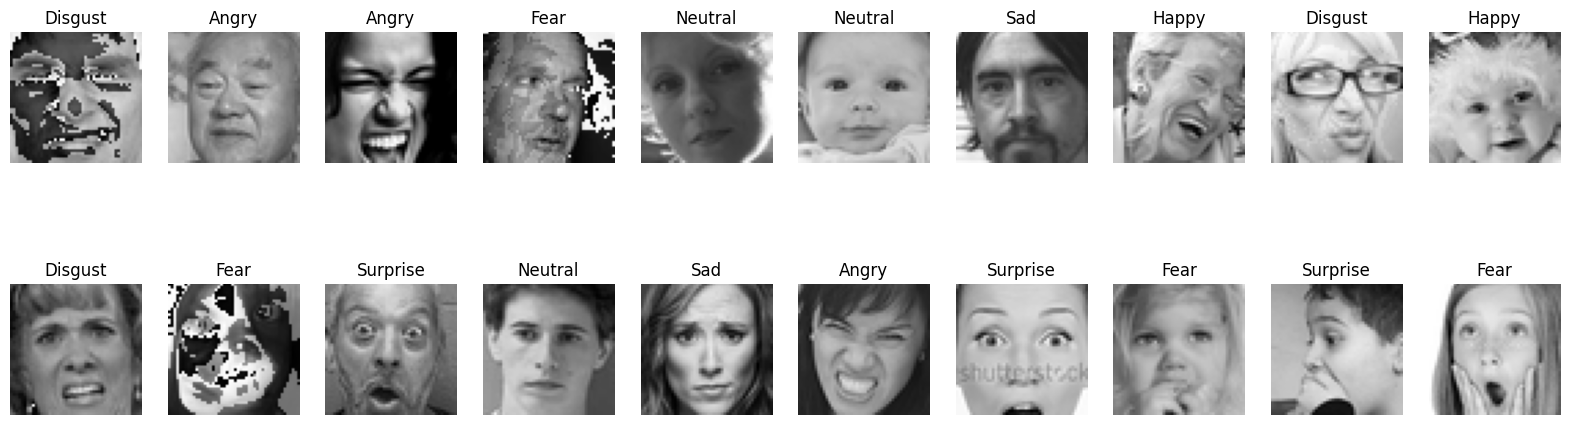

In [31]:
random.seed(42)
random_numbers = [random.randint(0, len(X_smote)) for _ in range(20)]

img_list = []
img_labels = []
for idx in random_numbers:
    image_string = X_smote[idx]
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48, 48, 3)
    img = Image.fromarray(image_data)
    img_list.append(img)
    img_labels.append(y_smote[idx])


fig, ax = plt.subplots(2, 10, figsize=(20, 6))
for i, img in enumerate(img_list):
    row, col = divmod(i, 10)
    ax[row, col].imshow(img, cmap="gray")
    ax[row, col].axis("off")
    ax[row, col].set_title(emotion_labels.get(img_labels[i]))

plt.show()

In [32]:
X_smote

array([[ 70,  70,  70, ...,  82,  82,  82],
       [151, 151, 151, ..., 184, 184, 184],
       [231, 231, 231, ..., 152, 152, 152],
       ...,
       [  3,   3,   3, ...,  72,  72,  72],
       [241, 241, 241, ..., 213, 213, 213],
       [103, 103, 103, ...,  73,  73,  73]], dtype=uint8)

In [33]:
pixels = [list(img.flatten()) for img in X_smote]

# Create a DataFrame
df = pd.DataFrame({
    'Label': y_smote,
    'Pixels': pixels
})

df['Pixels'] = df['Pixels'].apply(lambda x: ', '.join(map(str, x)))

df.head()

,Label,Pixels
0,0,"70, 70, 70, 80, 80, 80, 82, 82, 82, 72, 72, 72..."
1,0,"151, 151, 151, 150, 150, 150, 147, 147, 147, 1..."
2,2,"231, 231, 231, 212, 212, 212, 156, 156, 156, 1..."
3,4,"24, 24, 24, 32, 32, 32, 36, 36, 36, 30, 30, 30..."
4,6,"4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [34]:
path = "../../data/processed/fer2013"

if not os.path.exists(path):
    os.makedirs(path)


# Export to CSV
df.to_csv(path + "/fer2013_balanced.csv", index=False, quoting=csv.QUOTE_NONE, escapechar=' ')